## Traditional features construction

Feature extraction from EACH image from the training data using image feature descriptor SIFT (Scale-invariant feature transform) (see https://docs.opencv.org/4.x/da/df5/ tutorial_py_sift_intro.html) with 128 dimensions for each keypoint (Note that you should obtain many keypoints from each image).Plot the keypoints on one image from your training dataset (see Fig 1 for one such figure). (0.5 point)

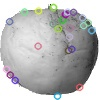

In [1]:
import numpy as np
import cv2 as cv
from IPython.display import Image, display

# Read the image
img = cv.imread('/content/drive/MyDrive/TrainingImages/Apple Golden 1/0_100.jpg')

# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Initialize the SIFT detector with 180 keypoints
sift = cv.SIFT_create(nfeatures=180)

# Detect keypoints
kp = sift.detect(gray, None)

# Draw keypoints on the original image
img_with_keypoints = cv.drawKeypoints(gray, kp, img)

# Save the image with keypoints
cv.imwrite('sift_keypoints.jpg', img_with_keypoints)

# Display the image
display(Image('sift_keypoints.jpg'))


Create a new keypoints dataset 𝐾 𝑃 that consists of all the keypoints from all the training images.

Perform K-mean clustering such that 𝐾 = 100 on 𝐾𝑃.

Use the learned K-mean clusters (seehttps://scikit-learn.org/stable/modules/clustering. html) to construct a 100-D vector for each image.

Example: For Image A, we have 20 keypoints in Cluster 1 and 10 keypoints in cluster 2, and no keypoints in the other clusters, then the vector representing Image A is
(20,10,0,0,0,...,0,0)

Create a new 100-D dataset 𝐷 consisting of vectors constructed from the training images.

In [2]:
from sklearn.cluster import KMeans
import cv2 as cv
import numpy as np
import os

# Initialize an empty list to store keypoints and labels
KP = []
labels = []

# List of directories containing your training images
dir_paths = ['/content/drive/MyDrive/TrainingImages/Apple Golden 1',
             '/content/drive/MyDrive/TrainingImages/Apple Red 1',
             '/content/drive/MyDrive/TrainingImages/Apple Red Delicious',
             '/content/drive/MyDrive/TrainingImages/Avocado',
             '/content/drive/MyDrive/TrainingImages/Ginger Root',
             '/content/drive/MyDrive/TrainingImages/Limes',
             '/content/drive/MyDrive/TrainingImages/Maracuja',
             '/content/drive/MyDrive/TrainingImages/Papaya',
             '/content/drive/MyDrive/TrainingImages/Potato Red',
             '/content/drive/MyDrive/TrainingImages/Rambutan'
             # Add more directory paths as needed
             ]

# Initialize SIFT detector
sift = cv.SIFT_create()

# Initialize a list to store the image vectors
image_vectors = []

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=100)

# Loop through each directory
for label, dir_path in enumerate(dir_paths):
    # Loop through each image file in the directory
    for filename in os.listdir(dir_path):
        # Read the image
        img = cv.imread(os.path.join(dir_path, filename))
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Detect keypoints
        kp = sift.detect(gray, None)
        # Append keypoints to list
        KP.append(kp)
        # Append label to the labels list
        labels.append(label)

# Fit KMeans to keypoints
kmeans.fit(np.concatenate([np.array([kp.pt for kp in kp]) for kp in KP]))

# Loop through each directory again to extract features
for label, dir_path in enumerate(dir_paths):
    # Loop through each image file in the directory
    for filename in os.listdir(dir_path):
        # Read the image
        img = cv.imread(os.path.join(dir_path, filename))
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Detect keypoints
        kp = sift.detect(gray, None)
        # Get cluster labels for the keypoints of this image
        image_labels = kmeans.predict(np.array([kp.pt for kp in kp]))
        # Count the occurrences of each cluster label
        cluster_counts = np.bincount(image_labels, minlength=100)
        # Append the cluster counts to the list of image vectors
        image_vectors.append(cluster_counts)

# Convert the list of image vectors to a numpy array
image_vectors_array = np.array(image_vectors)

# Ensure each vector follows the specified structure
for i in range(len(image_vectors_array)):
    # Find the indices where the count is nonzero
    nonzero_indices = np.nonzero(image_vectors_array[i])[0]
    # Create a new vector with counts only at those indices
    new_vector = np.zeros_like(image_vectors_array[i])
    new_vector[nonzero_indices] = image_vectors_array[i][nonzero_indices]
    # Replace the original vector with the new one
    image_vectors_array[i] = new_vector

# Convert the list of labels to a numpy array
labels_array = np.array(labels)

# Print an example vector
example_vector = image_vectors_array[0]
print("Example vector representing Image A:", example_vector)

# Print the shape of the dataset D
print("Shape of dataset D:", image_vectors_array.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Example vector representing Image A: [0 0 1 3 0 0 3 2 1 0 0 1 0 0 0 1 0 0 3 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1
 0 1 1 0 1 1 0 0 2 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 4 3 0 0 0 0 2 0 2 1 1
 1 0 1 0 2 0 2 0 2 0 0 0 0 2 1 0 1 0 1 1 0 1 3 0 1 0]
Shape of dataset D: (4665, 100)


Dimensionality reduction(using Principal Component Analysis,PCA)(seehttps://scikit-learn. org/stable/modules/generated/sklearn.decomposition.PCA.html for PCA. https:// scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html for code example.)

i. Perform Principal Component Analysis (PCA) dimensionality reduction Dataset 𝐷 to 2 dimensions. (Note: You should not use the class labels)

ii. Plot the 2D points using 10 different colors/symbols for data from the 10 classes (see Figure 2 for an example of the plot without normalization).(1 point)

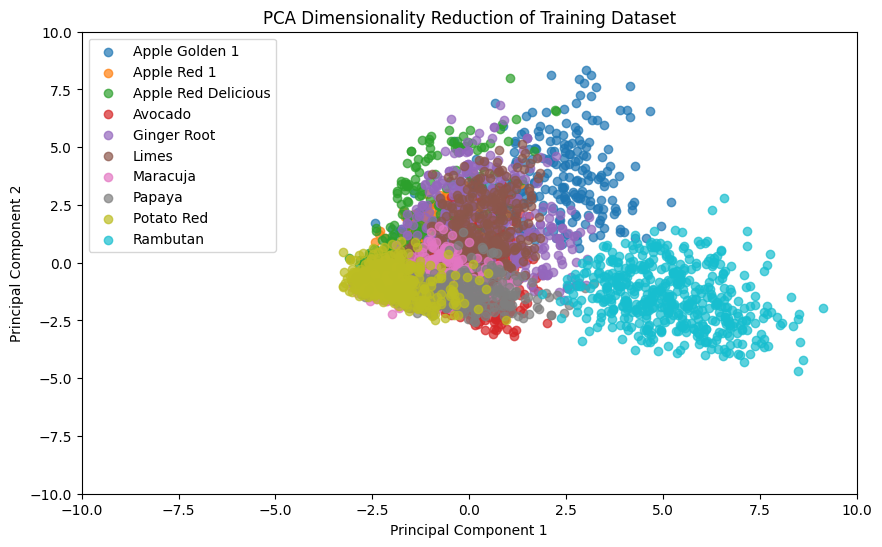

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# List of directories containing your training images
train_dir_paths = ['/content/drive/MyDrive/TrainingImages/Apple Golden 1',
                   '/content/drive/MyDrive/TrainingImages/Apple Red 1',
                   '/content/drive/MyDrive/TrainingImages/Apple Red Delicious',
                   '/content/drive/MyDrive/TrainingImages/Avocado',
                   '/content/drive/MyDrive/TrainingImages/Ginger Root',
                   '/content/drive/MyDrive/TrainingImages/Limes',
                   '/content/drive/MyDrive/TrainingImages/Maracuja',
                   '/content/drive/MyDrive/TrainingImages/Papaya',
                   '/content/drive/MyDrive/TrainingImages/Potato Red',
                   '/content/drive/MyDrive/TrainingImages/Rambutan']

# Initialize a list to store the image vectors
train_image_vectors = []
# Initialize a list to store the corresponding class labels
train_labels = []

# Loop through each directory
for label, dir_path in enumerate(train_dir_paths):
    # Loop through each image file in the directory
    for filename in os.listdir(dir_path):
        # Read the image
        img = cv.imread(os.path.join(dir_path, filename))
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Detect keypoints
        kp = sift.detect(gray, None)
        # Get cluster labels for the keypoints of this image
        image_labels = kmeans.predict(np.array([kp.pt for kp in kp]))
        # Count the occurrences of each cluster label
        cluster_counts = np.bincount(image_labels, minlength=100)
        # Append the cluster counts to the list of image vectors
        train_image_vectors.append(cluster_counts)
        # Assign class label based on folder name
        train_labels.append(os.path.basename(dir_path))

# Convert the lists to numpy arrays
train_image_vectors_array = np.array(train_image_vectors)
train_labels_array = np.array(train_labels)

# Perform PCA dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
D_pca = pca.fit_transform(train_image_vectors_array)

# Plot the 2D points with different colors/symbols for each class
plt.figure(figsize=(10, 6))
for label in np.unique(train_labels_array):
    class_indices = np.where(train_labels_array == label)[0]
    plt.scatter(D_pca[class_indices, 0], D_pca[class_indices, 1], label=f'{label}', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Dimensionality Reduction of Training Dataset')
plt.legend()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()


## “Traditional” Machine Learning Model - Support Vector Machine (SVM)

(a) We perform model selection to learn a linear SVM (see https://scikit-learn.org/stable/ modules/generated/sklearn.svm.SVC.html) prediction model (i.e., kernel = ‘linear’).

(b) Train the SVM model using different 𝐶 parameters. In particular, you will use the following values: 0.01, 0.1, 1.0, 10, 100.

(c) Plot a graph to show the SVM performance on the training data and test data similar to

(d) Repeat Step (b) and (c) for kernel = ’rbf’, ’poly’, ’sigmoid’. (2 points - include 0.5 for linear kernel.)

(e) Plot a graph to compare the best performance for SVM using the four kernels on the training data and test data similar to Figure 4 (note that you identify the best results for each kernel from results in Step (d))

### First, performing the same steps on testing data to create testing dataset

Combine all the keypoints from all the testing images into a single dataset.

Use the 100 cluster centers obtained from the training data to create a 100D vector for each test image.

Process the test images into the test dataset.

This code will create the test_image_vectors_array with the features obtained using the cluster centers obtained from the training data.

In [4]:
# List of directories containing your testing images
test_dir_paths = ['/content/drive/MyDrive/TestingImages/Apple Golden 1',
                  '/content/drive/MyDrive/TestingImages/Apple Red 1',
                  '/content/drive/MyDrive/TestingImages/Apple Red Delicious',
                  '/content/drive/MyDrive/TestingImages/Avocado',
                  '/content/drive/MyDrive/TestingImages/Ginger Root',
                  '/content/drive/MyDrive/TestingImages/Limes',
                  '/content/drive/MyDrive/TestingImages/Maracuja',
                  '/content/drive/MyDrive/TestingImages/Papaya',
                  '/content/drive/MyDrive/TestingImages/Potato Red',
                  '/content/drive/MyDrive/TestingImages/Rambutan',
                  # Add more directory paths as needed
                  ]

# Initialize an empty list to store keypoints for testing data
test_KP = []

# Initialize a list to store the image vectors for testing data
test_image_vectors = []

# Initialize a list to store the labels for testing data
test_labels = []

# Loop through each directory for testing data
for label, dir_path in enumerate(test_dir_paths):
    # Loop through each image file in the directory
    for filename in os.listdir(dir_path):
        # Read the image
        img = cv.imread(os.path.join(dir_path, filename))

        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect keypoints
        kp = sift.detect(gray, None)

        # Append keypoints to the test_KP dataset
        test_KP.extend(kp)

        # Get cluster labels for the keypoints of this image for testing data
        image_labels = kmeans.predict(np.array([kp.pt for kp in kp]))

        # Count the occurrences of each cluster label
        cluster_counts = np.bincount(image_labels, minlength=100)

        # Append the cluster counts to the list of image vectors for testing data
        test_image_vectors.append(cluster_counts)

        # Append label to the test_labels list
        test_labels.append(label)

# Convert the list of keypoints to an array for testing data
test_KP_array = np.array([kp.pt for kp in test_KP])

# Convert the list of image vectors to a numpy array for testing data
test_image_vectors_array = np.array(test_image_vectors)

# Convert the list of labels to a numpy array for testing data
test_labels_array = np.array(test_labels)

# Ensure each vector follows the specified structure for testing data
for i in range(len(test_image_vectors_array)):
    # Find the indices where the count is nonzero
    nonzero_indices = np.nonzero(test_image_vectors_array[i])[0]
    # Create a new vector with counts only at those indices
    new_vector = np.zeros_like(test_image_vectors_array[i])
    new_vector[nonzero_indices] = test_image_vectors_array[i][nonzero_indices]
    # Replace the original vector with the new one for testing data
    test_image_vectors_array[i] = new_vector

# Print an example vector for testing data
example_vector_test = test_image_vectors_array[0]  # Assuming the first image is Image A
print("Example vector representing Image A for testing data:", example_vector_test)

# Print the shape of the testing dataset D
print("Shape of testing dataset D:", test_image_vectors_array.shape)


Example vector representing Image A for testing data: [0 5 0 0 0 0 0 0 2 1 0 0 0 0 0 1 0 1 0 0 3 0 0 0 0 4 0 0 0 0 0 2 1 1 2 2 1
 0 1 3 1 0 0 2 0 0 0 0 0 2 1 4 0 2 0 2 0 0 0 1 6 1 0 2 1 0 0 0 0 0 0 2 1 0
 0 1 0 1 2 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
Shape of testing dataset D: (1542, 100)


### Now, we train the model and test it (using classes from the training images as labels)

The below code uses the default kernel function for the Support Vector Classifier (SVC) in scikit-learn, which is the Radial Basis Function (RBF) kernel.

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define C values
C_values = [0.01, 0.1, 1.0, 10, 100]

# Initialize dictionaries to store results
train_scores = {}
test_scores = {}

# Train SVM models for different C values
for C in C_values:
    # Initialize SVM model
    svm_model = SVC(C=C)

    # Train the model
    svm_model.fit(image_vectors_array, labels_array)

    # Predictions on training data
    train_predictions = svm_model.predict(image_vectors_array)

    # Accuracy on training data
    train_accuracy = accuracy_score(labels_array, train_predictions)
    train_scores[C] = train_accuracy

    # Predictions on testing data
    test_predictions = svm_model.predict(test_image_vectors_array)

    # Accuracy on testing data
    test_accuracy = accuracy_score(test_labels_array, test_predictions)
    test_scores[C] = test_accuracy

# Print the results
for C in C_values:
    print(f"C Value: {C}")
    print(f"Training Accuracy: {train_scores[C]:.4f}")
    print(f"Testing Accuracy: {test_scores[C]:.4f}")
    print()


C Value: 0.01
Training Accuracy: 0.2118
Testing Accuracy: 0.2088

C Value: 0.1
Training Accuracy: 0.8840
Testing Accuracy: 0.6751

C Value: 1.0
Training Accuracy: 0.9949
Testing Accuracy: 0.7341

C Value: 10
Training Accuracy: 1.0000
Testing Accuracy: 0.7451

C Value: 100
Training Accuracy: 1.0000
Testing Accuracy: 0.7445



In the context of Support Vector Machines (SVM), C values represent the regularization parameter.

Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. In SVM, the parameter
C controls the trade-off between maximizing the margin (decision boundary) and minimizing the classification error.

A small C value allows for a larger margin but may misclassify some points (soft margin).
A large C value penalizes misclassifications heavily, potentially resulting in a smaller margin (hard margin).

In essence, C values determine the balance between achieving a low training error and generalizing well to unseen data.

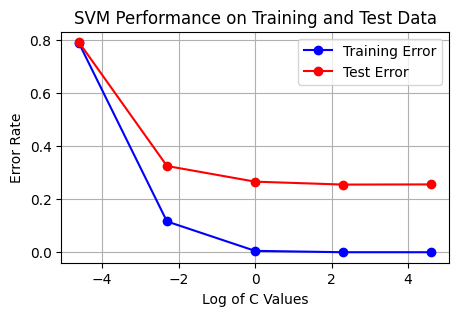

In [6]:
import matplotlib.pyplot as plt

# Calculate error rates
train_errors = [1 - train_scores[C] for C in C_values]
test_errors = [1 - test_scores[C] for C in C_values]

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(np.log(C_values), train_errors, marker='o', label='Training Error', color='blue')
plt.plot(np.log(C_values), test_errors, marker='o', label='Test Error', color='red')
plt.xlabel('Log of C Values')
plt.ylabel('Error Rate')
plt.title('SVM Performance on Training and Test Data')
plt.grid(True)
plt.legend()
plt.show()




An error rate of 0.3 means that 30% of the samples in the test data are classified incorrectly by the model.

We repeat for kernel = 'linear', ’RBF’, ’poly’, ’sigmoid’




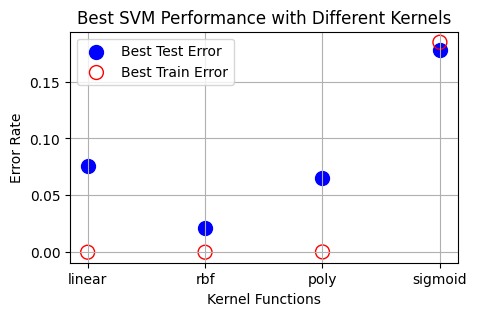

Error: Unable to load the image


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define C values
C_values = [0.01, 0.1, 1.0, 10, 100]

# Split the data into training and testing sets
train_image_vectors_array, test_image_vectors_array, train_labels_array, test_labels_array = \
    train_test_split(image_vectors_array, labels_array, test_size=0.2, random_state=42)

# Define kernel functions
kernel_functions = ['linear', 'rbf', 'poly', 'sigmoid']

# Initialize dictionaries to store results
train_errors = {kernel: [] for kernel in kernel_functions}
test_errors = {kernel: [] for kernel in kernel_functions}
best_test_errors = {kernel: float('inf') for kernel in kernel_functions}
best_train_errors = {kernel: float('inf') for kernel in kernel_functions}
best_test_C_values = {kernel: None for kernel in kernel_functions}
best_train_C_values = {kernel: None for kernel in kernel_functions}

# Train SVM models for different kernel functions and C values
for kernel in kernel_functions:
    for C in C_values:
        # Initialize SVM model
        svm_model = SVC(kernel=kernel, C=C)

        # Train the model
        svm_model.fit(train_image_vectors_array, train_labels_array)

        # Predictions on training data
        train_predictions = svm_model.predict(train_image_vectors_array)

        # Error rate on training data
        train_error = 1.0 - accuracy_score(train_labels_array, train_predictions)

        # Predictions on testing data
        test_predictions = svm_model.predict(test_image_vectors_array)

        # Error rate on testing data
        test_error = 1.0 - accuracy_score(test_labels_array, test_predictions)

        # Store errors
        train_errors[kernel].append(train_error)
        test_errors[kernel].append(test_error)

        # Update best test error for this kernel
        if test_error < best_test_errors[kernel]:
            best_test_errors[kernel] = test_error
            best_test_C_values[kernel] = C

        # Update best train error for this kernel
        if train_error < best_train_errors[kernel]:
            best_train_errors[kernel] = train_error
            best_train_C_values[kernel] = C

# Plotting
plt.figure(figsize=(5, 3))

# Plot testing data errors
for kernel in kernel_functions:
    plt.scatter([kernel], [best_test_errors[kernel]], color='blue', marker='o', s=100)

# Plot training data errors
for kernel in kernel_functions:
    plt.scatter([kernel], [best_train_errors[kernel]], color='none', edgecolor='red', s=100)

# Add labels outside the loop
plt.scatter([], [], color='blue', marker='o', label='Best Test Error', s=100)
plt.scatter([], [], color='none', edgecolor='red', label='Best Train Error', s=100)

# Add legend
plt.legend()
plt.xlabel('Kernel Functions')
plt.ylabel('Error Rate')
plt.title('Best SVM Performance with Different Kernels')
plt.grid(True)
plt.legend()
plt.show()

# Read the testing image
image_path = '/content/drive/MyDrive/TestingImages/Limes/lime.jpg'
testing_image = cv2.imread(image_path)

# Check if the image is loaded successfully
if testing_image is not None:
    # Display the testing image
    plt.imshow(cv2.cvtColor(testing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Use the trained SVM model to predict the label of the testing image
    predicted_label = svm_model.predict([testing_image.flatten()])

    # Print the predicted label
    print(f"Predicted Label: {predicted_label}")
else:
    print("Error: Unable to load the image")


This code plots the best performance (lowest error rate) for each kernel for both the testing and training datasets. It identifies the best performing C value for each kernel based on the lowest error rate achieved on the respective dataset.

# Deep Learning - Training a Simple Convolution Neural Network Model


First get the height and width of the images,

In [8]:
import cv2

# Read one image from the training set
sample_image_path = "/content/drive/MyDrive/TrainingImages/Apple Golden 1" + '/' + os.listdir("/content/drive/MyDrive/TrainingImages/Apple Golden 1")[0]
sample_image = cv2.imread(sample_image_path)

# Get the height and width of the image
image_height, image_width, _ = sample_image.shape

print("Image Height:", image_height)
print("Image Width:", image_width)


Image Height: 100
Image Width: 100
